---

<h1> <center> ProjectOAK </center> </h1>  

<h3> <center> By Sam Evans and Maria Yampolskaya </center> </h3>

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os #to check if model weights exist.

try:
    import QOL.plots as pqol #custom plotting stuff for Sam
    pqol.fixfigsize((1,1))
    pqol.scale_fonts((2,2))
except:
    print('pqol not loaded, defaulting to matplotlib.pyplot.')
    pqol=plt

import ImageProcessing as ip #ProjectOAK file with image processing functions.
import  DataProcessing as dp #ProjectOAK file with data  processing functions.
import  ScrapedLoading as sl #ProjectOAK file with functions for loading data from bulba-scraped dataset
#''' #comment this line while developing the ProjectOAK files above; this will force reloads of the files when runnign this cell.
from importlib import reload 
reload(ip)
reload(dp)
reload(sl)
#''';

<module 'ScrapedLoading' from '/Users/Sevans/Python/ProjectOAK/ScrapedLoading.py'>

In [2]:
SHOW_EXAMPLES = False          #whether to show examples throughout notebook. If False, hide most examples, for brevity.
Ntypes = dp.NTYPES             #number of types; probably 18; could be less if using "metatypes".

---
<h2> <center> Load the Pokémon Data! </center> </h2>  

---

In [3]:
## Options here.
READ_DATA     = [4]     #which folders to read data from.
INCLUDE_DATA  = [4]     #which folders to include.
CHANNEL_SHAPE = (200,200)   #choose shape for images. (for a single channel of the image.)
REREAD = False              #whether to reread images if a get_images cell is run more than once.

#folders to read from:
dp.IMAGESFOLDER1J = dp.IMAGESFOLDER1J  #enter a custom folder on the right if desired.
dp.IMAGESFOLDER2J = dp.IMAGESFOLDER2J  #enter a custom folder on the right if desired.
dp.IMAGESFOLDER3  = dp.IMAGESFOLDER3   #enter a custom folder on the right if desired.

for i in INCLUDE_DATA: assert i in READ_DATA

## Final variables which will store all the info:
used_rows_compiled   = []
used_labels_compiled = []
used_images_compiled = []
compiled_already = []    #track what has already been compiled; ensures no errors if a cell below is run more than once.
read_already = []        #track what has already been read; ensures no rereading if reread is false and a cell is run more than once.

In [4]:
## get data from csv file about pokemon.
csvdata, cc = dp.read_csv(dp.CSVFILE2)

Took  0.01 seconds to read data from dataset/Pokedex_Ver6.csv


## Get images from `IMAGESFOLDER1J`.
This is the dataset we started with originally. Image names are pokemon names. (J is for jpg)

In [5]:
if 1 in READ_DATA and (REREAD or not 1 in read_already):
    allimages1   = ip.get_all_images(dp.IMAGESFOLDER1J)
    if 1 not in read_already: read_already+=[1]   #just for convenience, doesn't do any reading work.

In [6]:
if 1 in INCLUDE_DATA:
    imagekeys1   = np.array(list(allimages1.keys()))
    imagekeys_title1 = np.array([key.title() for key in imagekeys1])
    seris1       = np.array(dp.pokes_to_S(imagekeys_title1, csvdata))    #serial numbers
    idx_include1 = (seris1 != '')
    used_images1 = np.array([allimages1[key] for key in imagekeys1[idx_include1]])
    used_rows1   = np.array(dp.vectorized_row_where(seris1[idx_include1], csvdata, cc.SERIAL))
    used_types1  = csvdata[used_rows1, cc.TYPE1]
    used_labels1 = dp.type_to_idx(used_types1)
    
    if 1 in compiled_already: print('Already compiled 1. If desired, reset via cell at top of section.')
    else:
        used_rows_compiled   += [used_rows1]
        used_labels_compiled += [used_labels1]
        used_images_compiled += [i/255. for i in ip.resize_images(used_images1, CHANNEL_SHAPE)] # /255 so that data falls in [0..1] range.
        compiled_already += [1]

## Get images from `IMAGESFOLDER2J`.
This is the ~70MB dataset with ~800 256x256x3 images. Image names are pokemon numbers. (J is for jpg)

In [7]:
if 2 in READ_DATA and (REREAD or not 2 in read_already):
    allimages2 = ip.get_all_images(dp.IMAGESFOLDER2J)
    if 2 not in read_already: read_already+=[2]   #just for convenience, doesn't do any reading work.

In [8]:
if 2 in INCLUDE_DATA:
    imagekeys2   = np.array(list(allimages2.keys()))
    seris2       = np.array(dp.Ns_to_S(imagekeys2, csvdata, code=1))    #serial numbers
    idx_include2 = (seris2 != '')
    used_images2 = np.array([allimages2[key] for key in imagekeys2[idx_include2]])
    used_rows2   = np.array(dp.vectorized_row_where(seris2[idx_include2], csvdata, cc.SERIAL))
    used_types2  = csvdata[used_rows2, cc.TYPE1]
    used_labels2 = dp.type_to_idx(used_types2)
    
    if 2 in compiled_already: print('Already compiled 2. If desired, reset via cell at top of section.')
    else:
        used_rows_compiled   += [used_rows2]
        used_labels_compiled += [used_labels2]
        used_images_compiled += [i/255. for i in ip.resize_images(used_images2, CHANNEL_SHAPE)] # /255 so that data falls in [0..1] range.
        compiled_already += [2]

## Get images from `IMAGESFOLDER3`.
This is the ~1.2GB dataset which has many images of each of the original 150 pokes.
- Structured as a folder with subfolders.
- Each subfolder is named with a pokemon name and contains images of that pokemon.
- The image shapes and filetypes are not standardized.
- See `ImageProcessing.images_from_folders_in_dir` for more details on how we process the data.

In [9]:
if 3 in READ_DATA and (REREAD or not 3 in read_already):
    N_images_per_poke = 10  #maximum number of images to get from each folder.
    shape3 = CHANNEL_SHAPE  #resizes each channel of each image to this shape.
    allimages3 = ip.images_from_folders_in_dir(dp.IMAGESFOLDER3, some=N_images_per_poke, shape=shape3, random=True) 
    if 3 not in read_already: read_already+=[3]   #just for convenience, doesn't do any reading work.

In [10]:
if 3 in INCLUDE_DATA:
    imagekeys3   = np.array(list(allimages3.keys()))
    seris3       = np.array(dp.pokes_to_S(imagekeys3, csvdata)) #serial numbers
    idx_include3 = (seris3 != '')  #ignore names not in csvdata. E.g. 'MrMime' (folder) vs 'Mr. Mime' (name in csvdata).
    used_imlists3 = [allimages3[key] for key in imagekeys3[idx_include3]] #each is a list of (up to <some>) images rather than a single image.
    used_rows3   = np.array(dp.vectorized_row_where(seris3[idx_include3], csvdata, cc.SERIAL))
    used_types3  = csvdata[used_rows3, cc.TYPE1]
    used_labels3 = dp.type_to_idx(used_types3)
    used_images3, fidx3 = ip.flatten_imlists(used_imlists3)

    if 3 in compiled_already: print('Already compiled 3. If desired, reset via cell at top of section.')
    else:
        used_rows_compiled   += [used_rows3[fidx3]]
        used_labels_compiled += [used_labels3[fidx3]]
        used_images_compiled += [i/255. for i in ip.resize_images(used_images3, CHANNEL_SHAPE)] # /255 so that data falls in [0..1] range.
        compiled_already += [3]


## Get images from `IMAGESFOLDER4`.
This is the ~2GB dataset which has many images of each of the original 150 pokes.
- Structured as a folder with subfolders.
- Each subfolder is named with a pokemon name and contains images of that pokemon.
- The image shapes and filetypes are not standardized.
- The file names are NNN-name.ext for the NNN'th image from bulbapedia archive website, image file named name.ext.
- `ScrapedLoading.py` contains a method to get only the filenames which are actually good to use.

In [11]:
if 4 in READ_DATA and (REREAD or not 4 in read_already):
    shape4 = CHANNEL_SHAPE  #resizes each channel of each image to this shape.
    #NL4 = sl.NamesLists(dp.IMAGESFOLDER4, NOSPRITES=True, csvdata=csvdata) #nameslists can be loaded without csvdata, but including it helps with selecting good images.
    NL4 = None #if using the scraped_cleaned_200 dataset, there is no need to use nameslists because all the images can be included!
    allimages4 = ip.images_from_folders_in_dir(dp.IMAGESFOLDER4C, shape=shape4, nameslists=NL4, random=False, some=np.inf, exclude_smaller=True)
    if 4 not in read_already: read_already+=[4]   #just for convenience, doesn't do any reading work.

Finished in 19.17 seconds.    Lotad


In [12]:
if 4 in INCLUDE_DATA:
    imagekeys4   = np.array(list(allimages4.keys()))
    seris4       = np.array(dp.pokes_to_S(imagekeys4, csvdata)) #serial numbers
    idx_include4 = (seris4 != '')  #ignore names not in csvdata. E.g. 'MrMime' (folder) vs 'Mr. Mime' (name in csvdata).
    used_imlists4= [allimages4[key] for key in imagekeys4[idx_include4]] #each is a list of (up to <some>) images rather than a single image.
    used_rows4   = np.array(dp.vectorized_row_where(seris4[idx_include4], csvdata, cc.SERIAL))
    used_types4  = csvdata[used_rows4, cc.TYPE1]
    used_labels4 = dp.type_to_idx(used_types4)
    used_images4, fidx4 = ip.flatten_imlists(used_imlists4)

    if 4 in compiled_already: print('Already compiled 4. If desired, reset via cell at top of section.')
    else:
        used_rows_compiled   += [used_rows4[fidx4]]
        used_labels_compiled += [used_labels4[fidx4]]
        used_images_compiled += [ip.resize_images(used_images4, CHANNEL_SHAPE)]  #the *255 is so that these images fall in [0..255]
        compiled_already += [4]


(No resizing necessary; image shape is already the desired shape.)


## Data compiled into single place for convenience

In [13]:
if 0 in compiled_already: print('Already concatenated compiled variables. If desired, reset via cell at top of section.')
else:
    used_rows_compiled   = np.concatenate(used_rows_compiled)
    now=time.time()
    print('Concatenating images, this may take a while...', end='')
    used_images_compiled = np.concatenate(used_images_compiled)
    print('\r', ' '*60, '\r', 'Finished concatenating images in {:5.2f} seconds'.format(time.time()-now), sep='')
    used_labels_compiled = np.concatenate(used_labels_compiled)
    compiled_already += [0]
    print('Data compiled fully; concatenation complete.')
if SHOW_EXAMPLES: print('Shape of used_images_compiled:',used_images_compiled.shape) 

Finished concatenating images in 10.42 seconds              
Data compiled fully; concatenation complete.


---
<h2> <center> Create Dataset Class Object </center> </h2>  

---
Note that `do_scaling=False` is fine if we are using data augmentation with `featurewise_center=True, featurewise_std_normalization=True`.

In [14]:
#'''
## make dataset with only stuff from IMAGESFOLDER2J
identifiers = csvdata[used_rows_compiled][:,[cc.NAME, cc.TYPE1, cc.TYPE2]]
#dd = dp.Full_Dataset(used_images2/255., meta_labels2, serials=identifiers, val_size=0.2, test_size=0.1, do_scaling=False)
dd = dp.Full_Dataset(used_images_compiled, used_labels_compiled, serials=identifiers,
                     val_size=0.2, test_size=0.1, do_scaling=False, watch_dups=True)

print('train_size: ', dd.train_size, ', val_size: ', dd.val_size, ', test_size: ', dd.test_size, sep='')

"""
## weight classes to counteract data imbalance.
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=range(MTYPES), y=dd.train_labels)
class_weight_dict = dict(enumerate(class_weights))
if SHOW_EXAMPLES: print(class_weight_dict)
#""";
#''';

|> Splitting data; ensuring duplicates stay together.
|> "Duplicates" determined by whether serials match. E.g. serial[0] = ['Abomasnow' 'Grass' 'Ice']
| setting: train_data     | setting: val_data       | setting: test_data      
| setting: train_labels   | setting: val_labels     | setting: test_labels    
| setting: train_serials  | setting: val_serials    | setting: test_serials   
train_size: 3583, val_size: 1023, test_size: 511


In [15]:
#read image shape
IMAGESHAPE = dd.train_data[0].shape
print("shape of images:",IMAGESHAPE)

shape of images: (200, 200, 3)


---
<h2> <center> A Wild Neural Network Appears! </center> </h2>  

---

## Single-type classification (the simplest problem)

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

### Set Up Data Augmentation

In [17]:
## SET UP DATA AUGMENTATION
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #featurewise_center=True,              #center features at 0.
    #featurewise_std_normalization=True,   #divide by each feature's std.
    #rescale = 1/255.,
    #rotation_range=45,       #rotate by up to this many degrees.
    #width_shift_range=0.2,   #shift by up to this fraction of the image, horizontally.
    #height_shift_range=0.2,  #shift by up to this fraction of the image, vertically.
    #vertical_flip=True,      #whether to sometimes flip images vertically.
    #horizontal_flip=True,    #whether to sometimes flip images horizontally.
    #zoom_range=0.2,          #zoom random within [0.8 .. 1.2]
    #shear_range=0.2,         #range for shear transformations
    #fill_mode='constant',    #fill extra pixels with constant
    #cval=255                 #constant = 255 ( --> 'white')
)
now=time.time()
datagen.fit(dd.train_data)    #fit to training data (and ONLY TRAINING DATA)
print('took {:5.2f} seconds to fit datagen.'.format(time.time()-now))

took  6.27 seconds to fit datagen.


In [18]:
#datagen.flow makes an iterator which returns
#     <batch_size> manipulated images (and original labels) from the input data given to it.
if SHOW_EXAMPLES:
    B = 10
    ims, lbs = next(datagen.flow(dd.train_data, dd.train_serials[:,0], batch_size=B))
    fig, axs = plt.subplots(2, B, figsize=(B,3))
    plt.suptitle('examples of augmented data images')
    for i in range(B):
        plt.sca(axs[0][i])
        plt.imshow(ims[i])
        plt.gca().yaxis.set_visible(False)
        plt.gca().xaxis.set_visible(False)
        plt.title(str(lbs[i]))

        plt.sca(axs[1][i])
        plt.imshow(dd.train_data[dd.train_serials[:,0]==lbs[i]][0]) #(this line is slow)
        plt.gca().yaxis.set_visible(False)
        plt.gca().xaxis.set_visible(False)
        plt.title('(original)')
    plt.tight_layout()
    plt.show()

### Define Network Architecture

In [44]:
def create_CNN():
    num_classes = Ntypes

    model = models.Sequential()
    
    #parameters: layers.Conv2D(numfilters, kernel_size, strides)
    model.add(layers.Conv2D(5, 2, 1, input_shape = IMAGESHAPE))
    model.add(layers.Activation('relu'))
    model.add(layers.AveragePooling2D(pool_size = (2,2)))
    
    model.add(layers.Conv2D(10, 4, 2))
    model.add(layers.Activation('relu'))
    model.add(layers.AveragePooling2D(pool_size = (2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(num_classes * 3, activation = 'relu'))
    model.add(layers.Dense(num_classes, activation = 'softmax'))

    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
            #tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name='stk1'),
            ]
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    style = dict(metrics=metrics, loss=loss)
    
    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), **style)
    #model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.2, nesterov=False, name="SGD"), **style)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(), **style)
    
    #
    return model

In [45]:
model = create_CNN()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 199, 199, 5)       65        
_________________________________________________________________
activation_8 (Activation)    (None, 199, 199, 5)       0         
_________________________________________________________________
average_pooling2d_8 (Average (None, 99, 99, 5)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 10)        810       
_________________________________________________________________
activation_9 (Activation)    (None, 48, 48, 10)        0         
_________________________________________________________________
average_pooling2d_9 (Average (None, 24, 24, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5760)             

### Train the Network

In [46]:
epochs = 50
batch_size = 32
verbose = 1

measure = dict(monitor='val_loss', mode='auto')

early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0, patience=3, verbose=0,
    baseline=None, restore_best_weights=True, **measure
)

# this line will SAVE the model weights to a file:
checkpointing = tf.keras.callbacks.ModelCheckpoint('model_checkpoints/myfirstmodel.h5',
    verbose=0, save_best_only=True, **measure)

callbacks = [early_stopping, checkpointing]

'''
history = model.fit(datagen.flow(dd.train_data, dd.train_labels, batch_size=batch_size),
          #          class_weight = class_weight_dict,
                    validation_data=(dd.val_data, dd.val_labels),
                    steps_per_epoch=len(dd.train_data) / batch_size, epochs=epochs,
                    callbacks = callbacks, verbose=verbose)
'''


history = model.fit(dd.train_data, dd.train_labels,
                    validation_data=(dd.val_data, dd.val_labels),
                    batch_size=batch_size,
#                    class_weight = class_weight_dict,
                    epochs=epochs,
                    callbacks = callbacks,
                    verbose=verbose)

# train the data for 500 epochs
#model.fit(data_train, labels_train, batch_size = 32, epochs = 500, verbose=1, validation_split = 0.1)
#model.evaluate(dd['val']['data'], dd['val']['labels'])

Epoch 1/50
114/114 [==============================] - 14s 123ms/step - loss: 2.7819 - acc: 0.1986 - val_loss: 2.7776 - val_acc: 0.1960
Epoch 2/50
114/114 [==============================] - 14s 120ms/step - loss: 2.7229 - acc: 0.2561 - val_loss: 2.7417 - val_acc: 0.2384
Epoch 3/50
114/114 [==============================] - 14s 121ms/step - loss: 2.7042 - acc: 0.2790 - val_loss: 2.7468 - val_acc: 0.2293
Epoch 4/50
114/114 [==============================] - 14s 120ms/step - loss: 2.6857 - acc: 0.2977 - val_loss: 2.6997 - val_acc: 0.2960
Epoch 5/50
114/114 [==============================] - 15s 135ms/step - loss: 2.6664 - acc: 0.3222 - val_loss: 2.7231 - val_acc: 0.2566
Epoch 6/50
114/114 [==============================] - 15s 133ms/step - loss: 2.6536 - acc: 0.3330 - val_loss: 2.7109 - val_acc: 0.2828
Epoch 7/50
114/114 [==============================] - 14s 120ms/step - loss: 2.6394 - acc: 0.3445 - val_loss: 2.7110 - val_acc: 0.2768


### Check network performance vs epoch

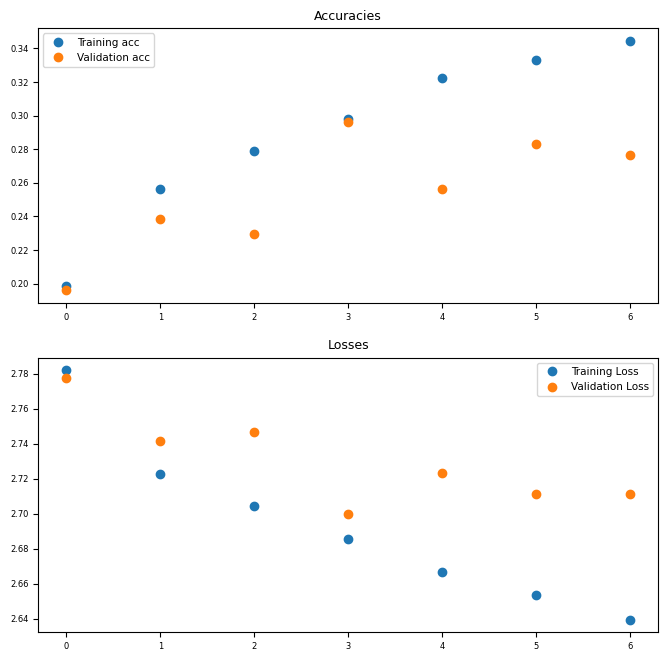

Maximum validation accuracy achieved: 0.29595959186553955


In [47]:
show_histories = 1
accstr = 'acc'
accstr2 = None

if show_histories:
    epochs = len(history.history['loss'])

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(range(epochs), history.history[accstr], 'o', label='Training '+accstr)
    plt.plot(range(epochs), history.history['val_'+accstr], 'o', label='Validation '+accstr)
    if accstr2 is not None:
        plt.plot(range(epochs), history.history[accstr2], 'x', label='Training '+accstr2)
        plt.plot(range(epochs), history.history['val_'+accstr2], 'x', label='Validation '+accstr2)
    plt.legend()
    plt.title('Accuracies')

    plt.subplot(2, 1, 2)
    plt.plot(range(epochs), history.history['loss'], 'o', label='Training Loss')
    plt.plot(range(epochs), history.history['val_loss'], 'o', label='Validation Loss')
    plt.legend()
    plt.title('Losses')
    plt.show()

    print("Maximum validation accuracy achieved: " + str(np.max(history.history['val_'+accstr])))

### Check predictions of model

In [48]:
## make the predictions
predictions = dp.prediction_to_idx(model.predict(dd.val_data)) #prediction = type with max probability.
assert len(predictions)==len(dd.val_data)

In [49]:
NUM_CLASSES = len(dp.ALLTYPES[:-1])
CLASSES = dp.ALLTYPES[:-1]

prediction (validation data)


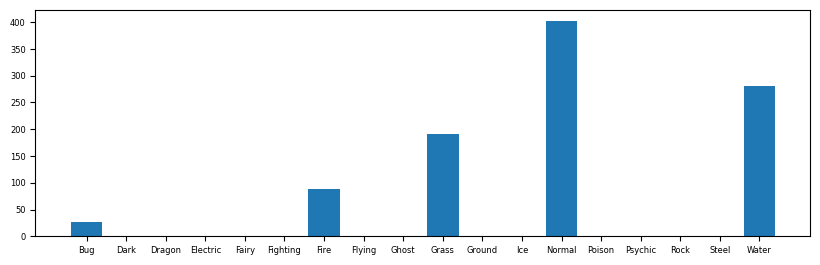

data (validation data)


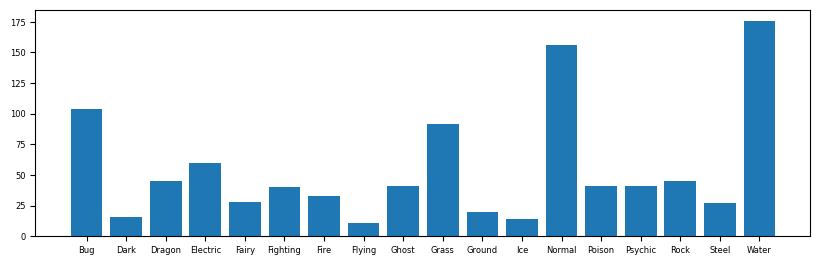

data (train data)


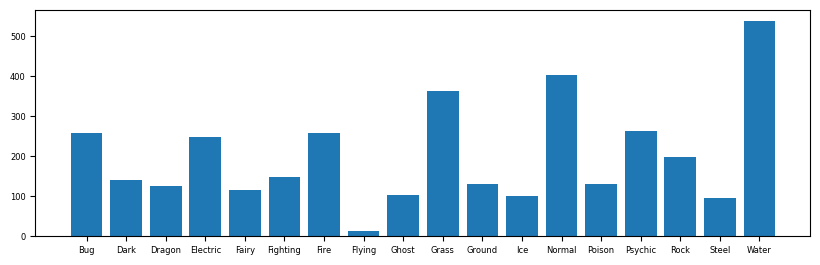

In [50]:
## show distribution of predicted types & distribution of types in the validation dataset
print('prediction (validation data)')
plt.figure(figsize=(10,3))
bc_p = np.bincount(predictions, minlength=NUM_CLASSES)
plt.bar(CLASSES, bc_p);
plt.show()
print('data (validation data)')
plt.figure(figsize=(10,3))
bc_v = np.bincount(dd.val_labels, minlength=NUM_CLASSES)
plt.bar(CLASSES, bc_v);
plt.show()
print('data (train data)')
plt.figure(figsize=(10,3))
bc_t = np.bincount(dd.train_labels, minlength=NUM_CLASSES)
plt.bar(CLASSES, bc_t);
plt.show()

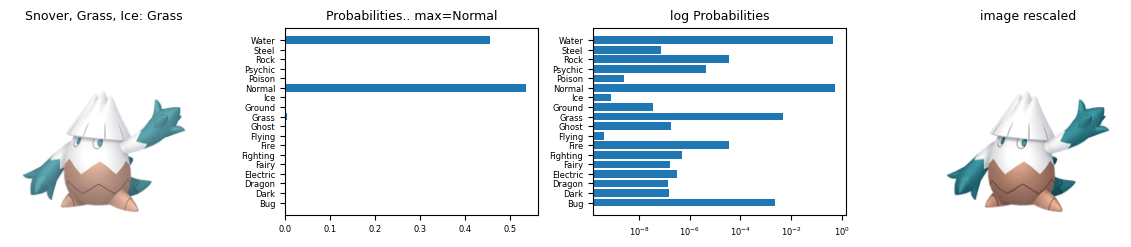

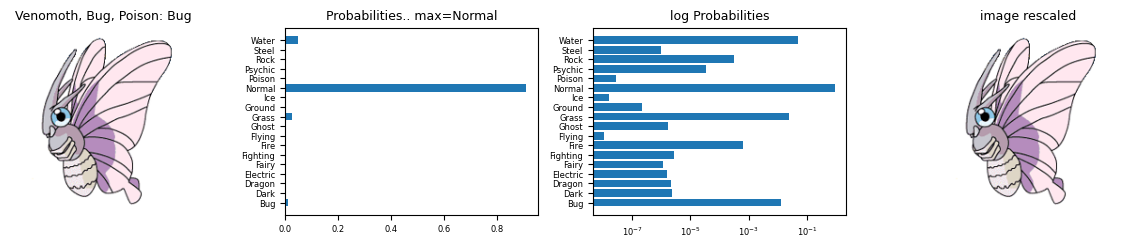

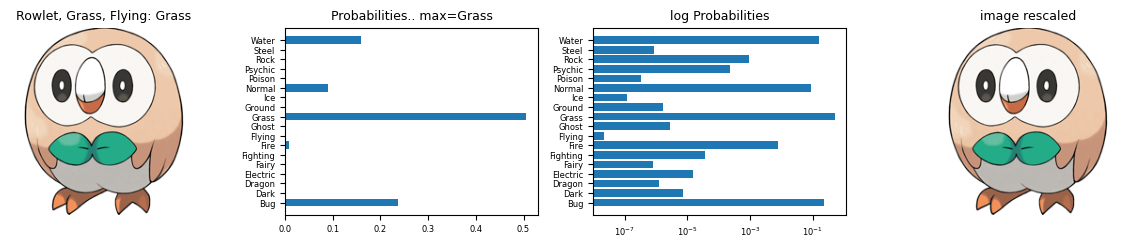

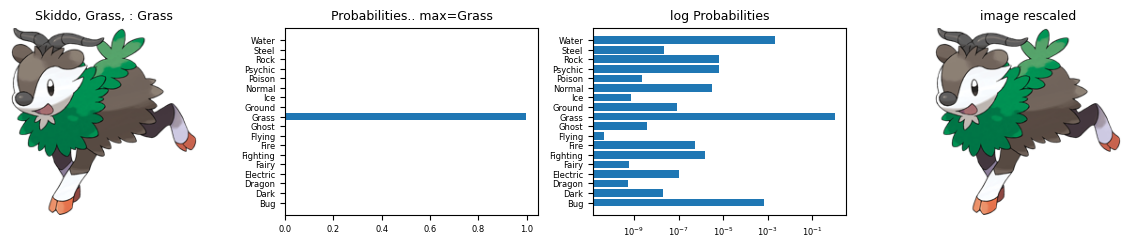

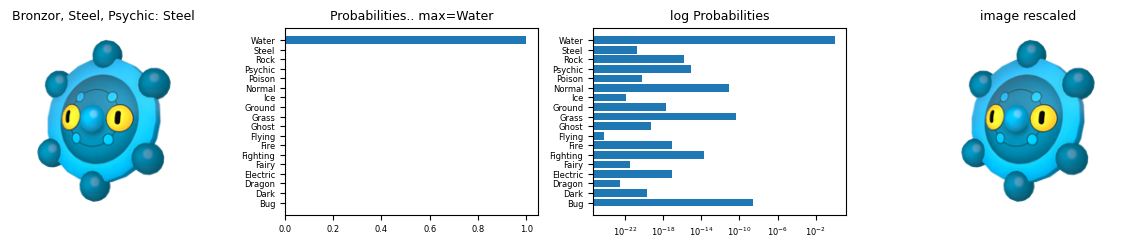

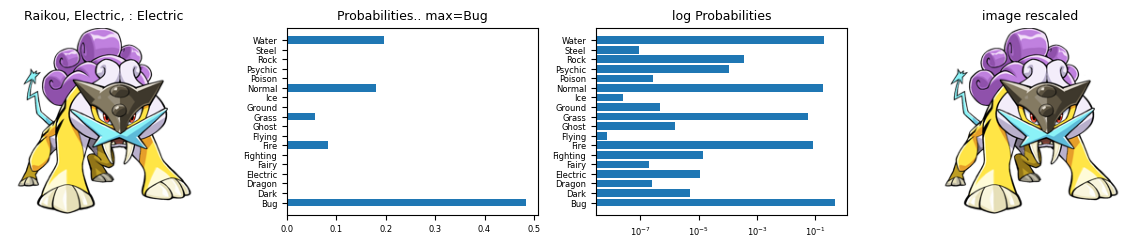

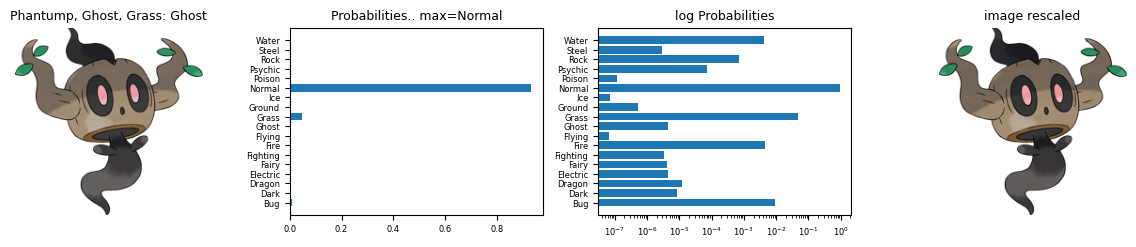

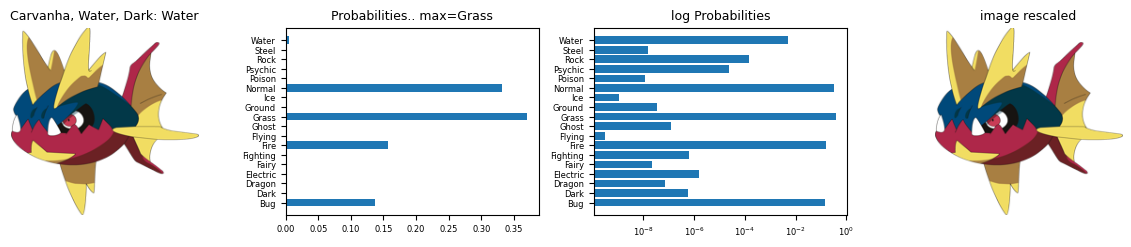

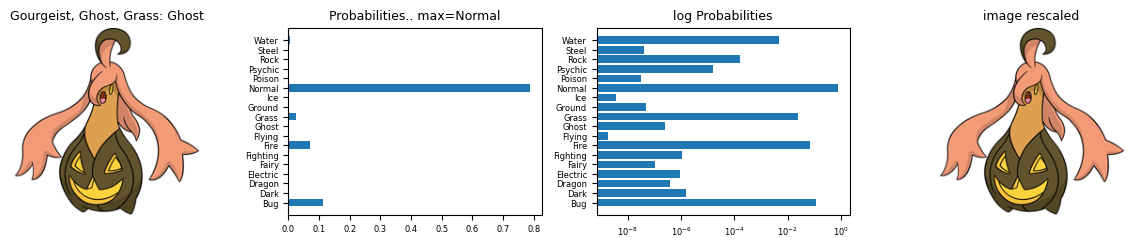

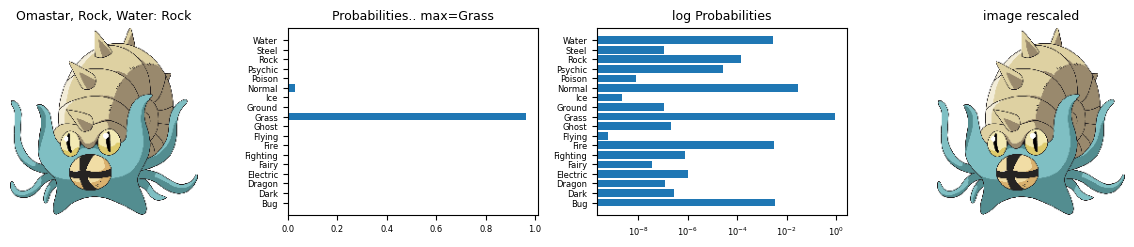

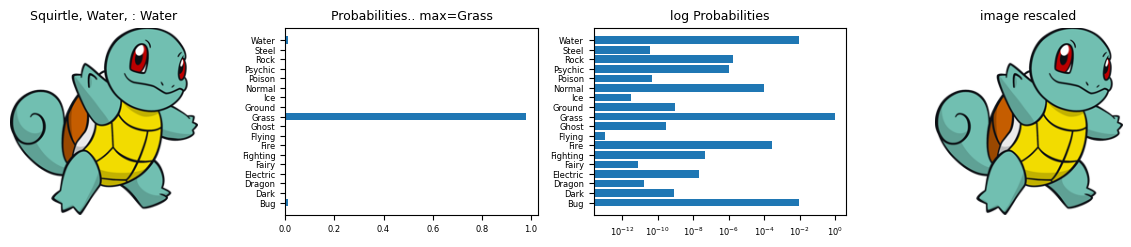

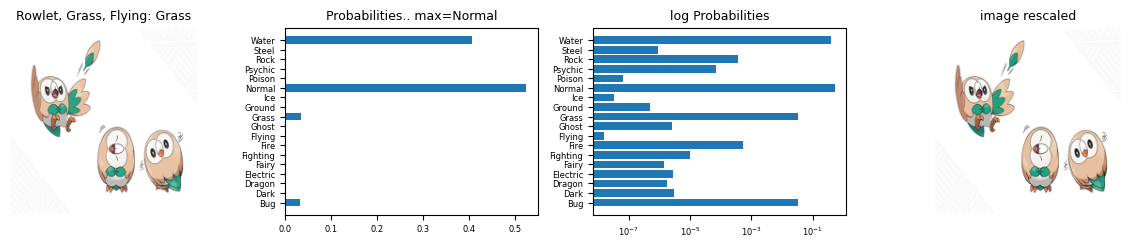

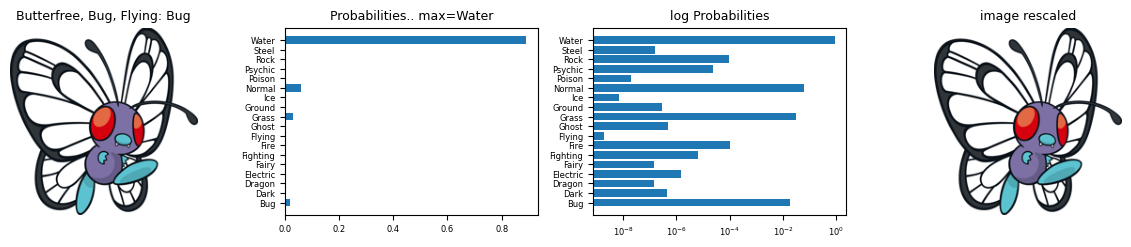

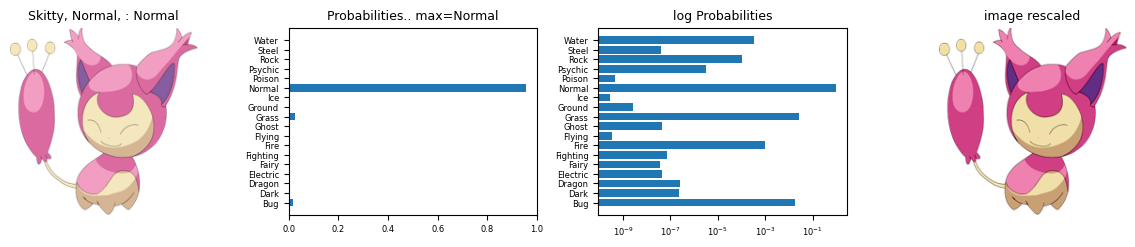

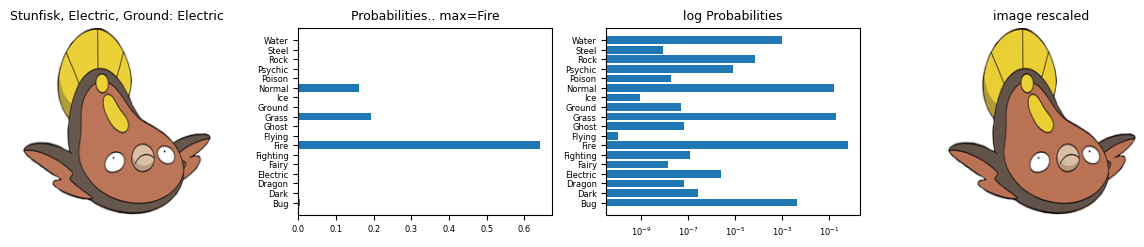

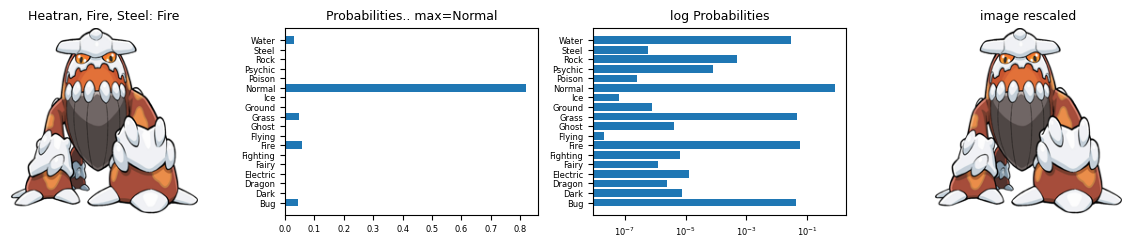

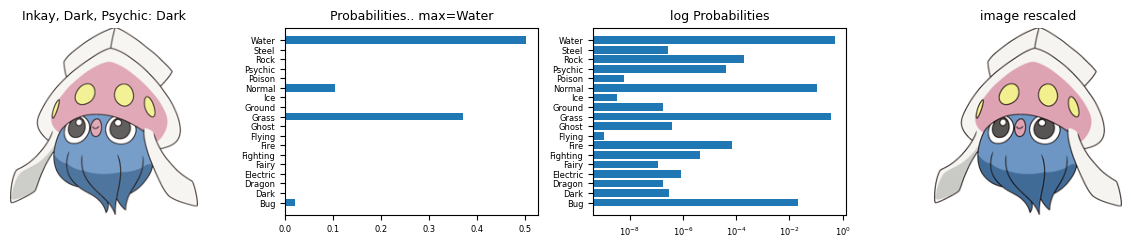

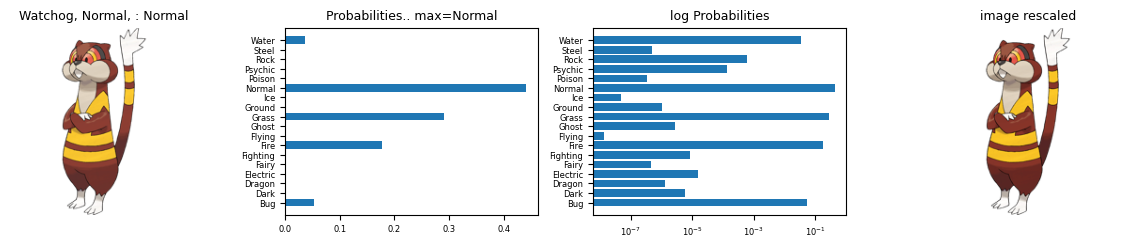

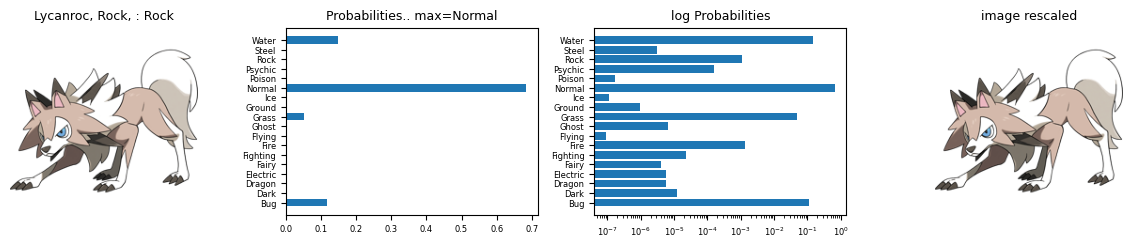

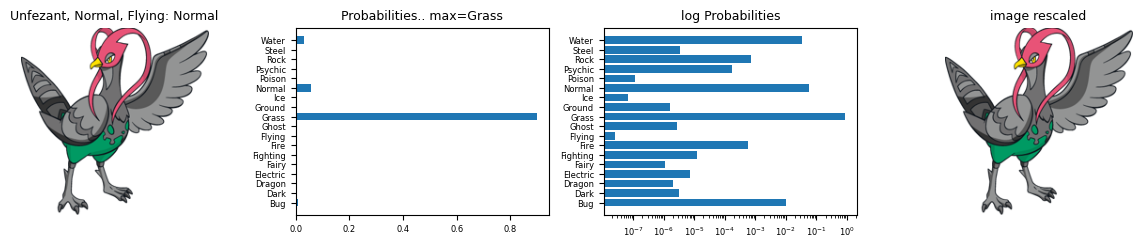

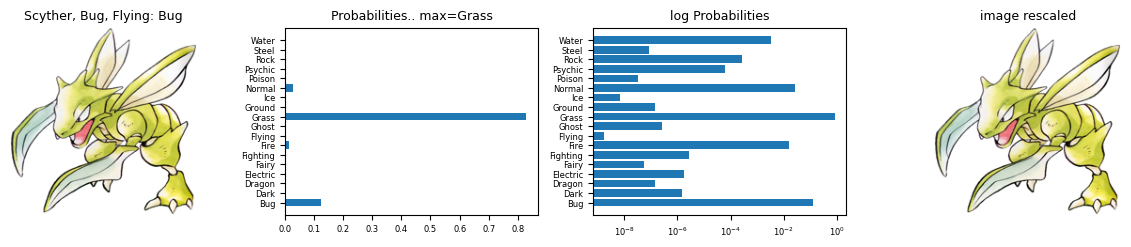

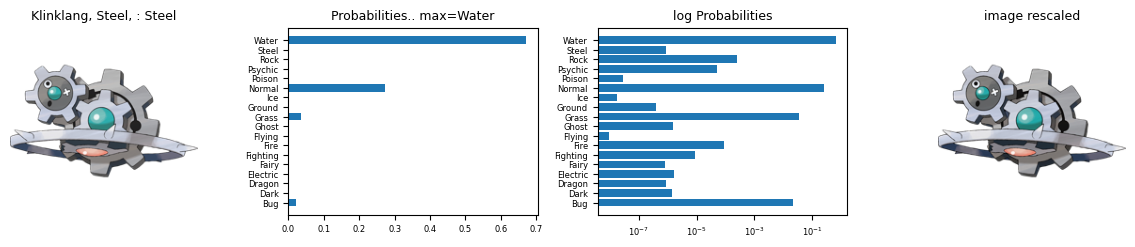

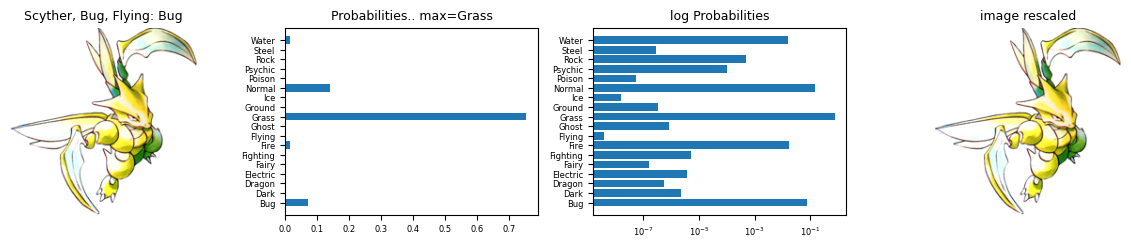

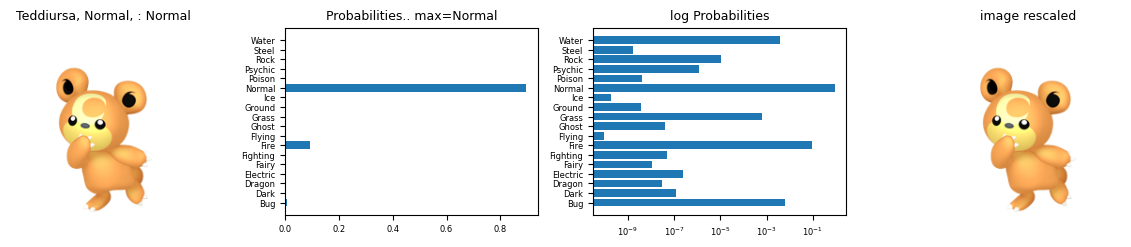

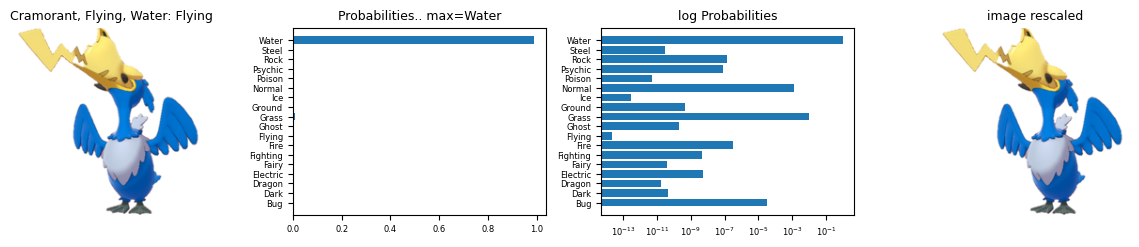

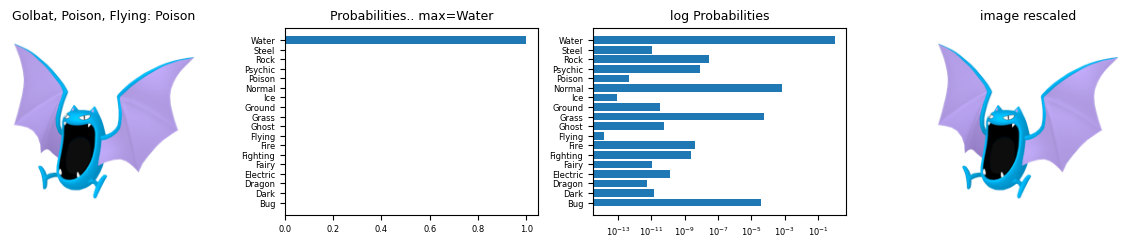

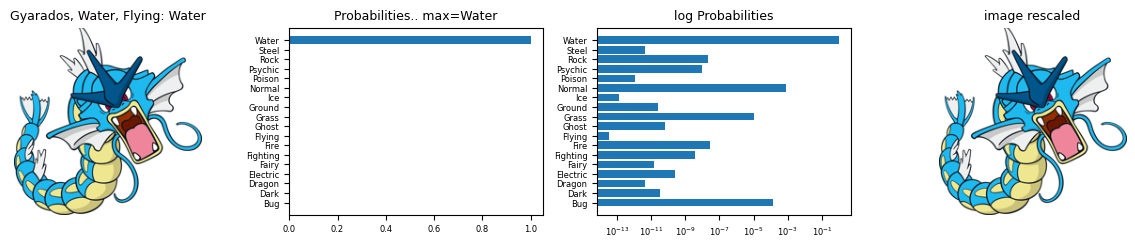

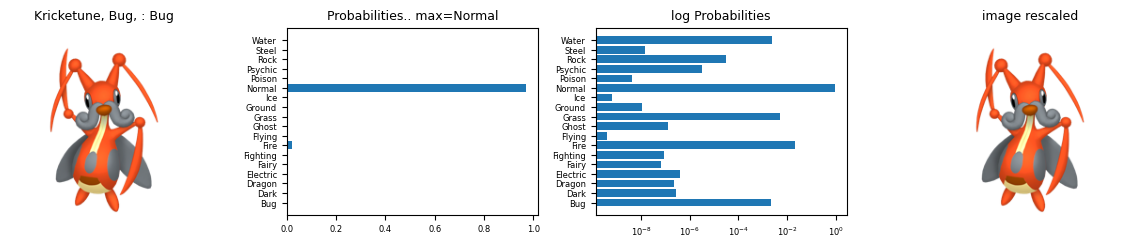

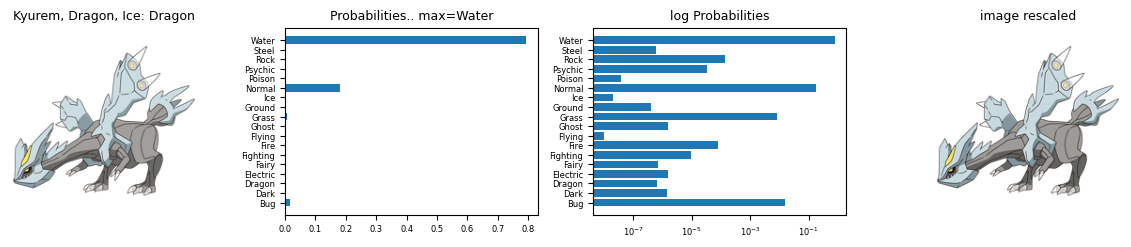

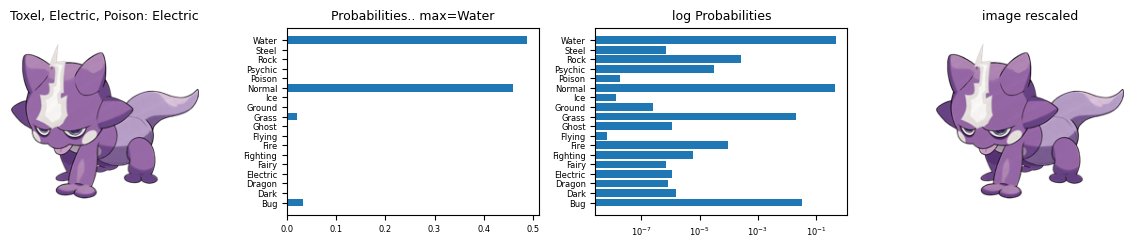

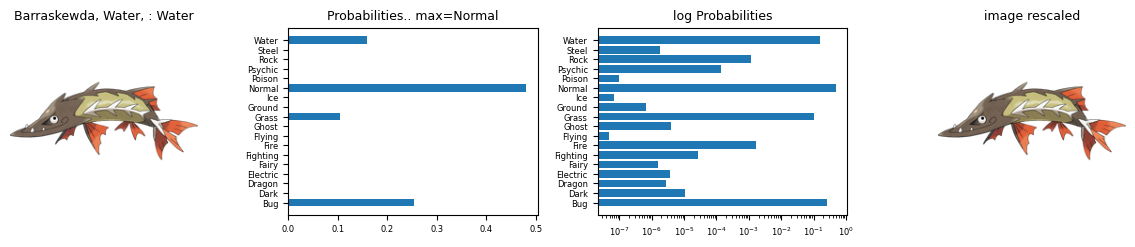

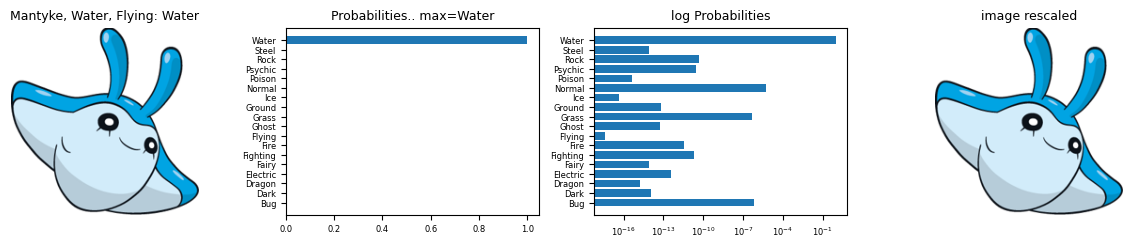

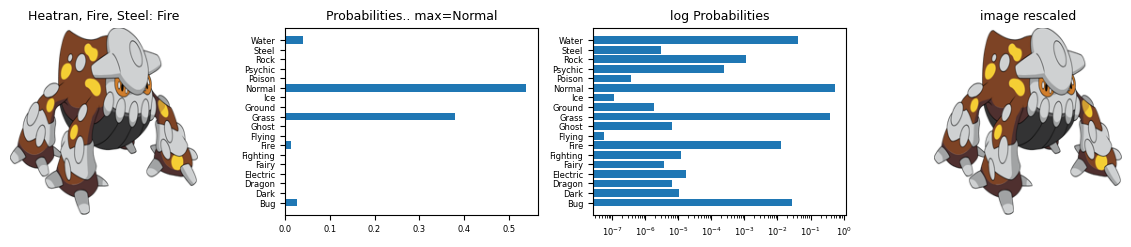

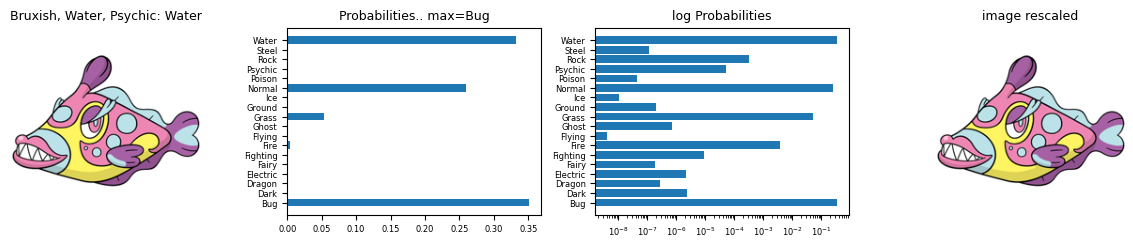

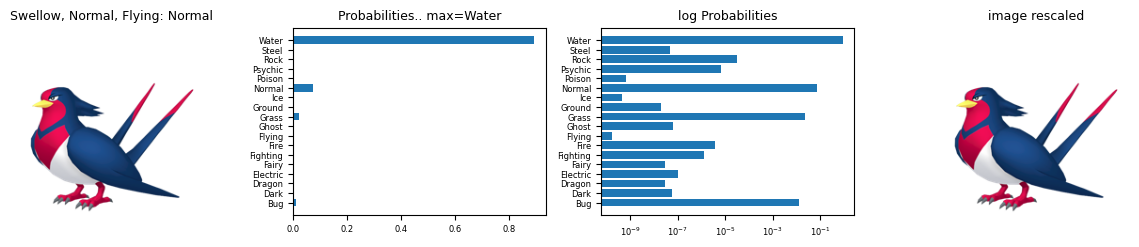

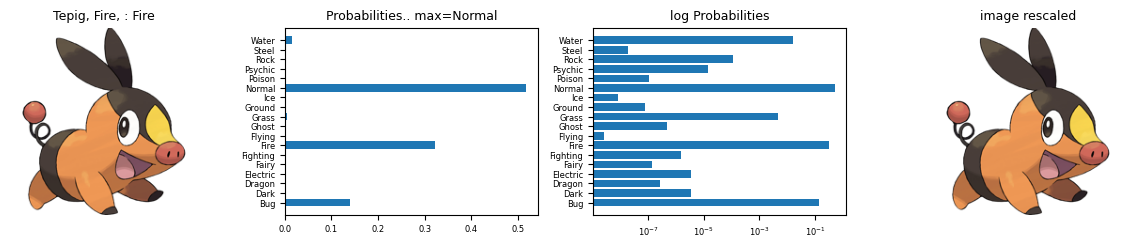

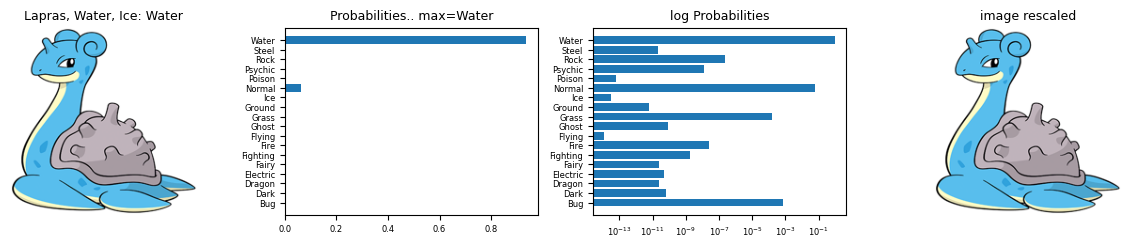

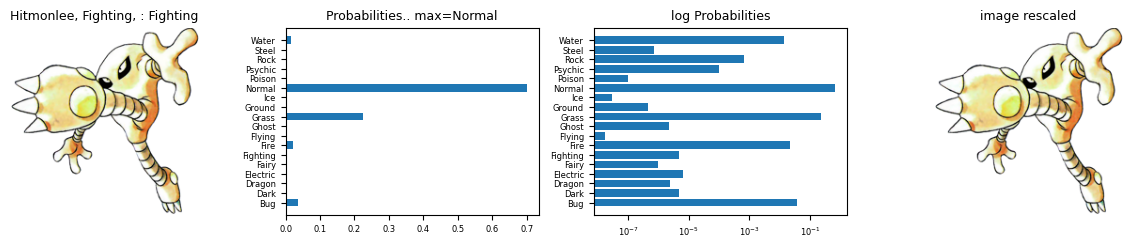

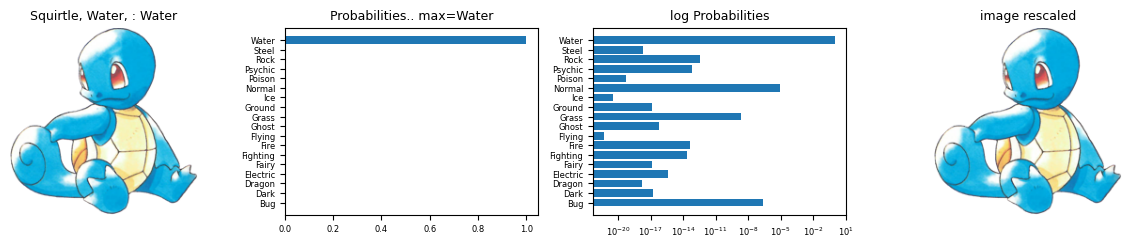

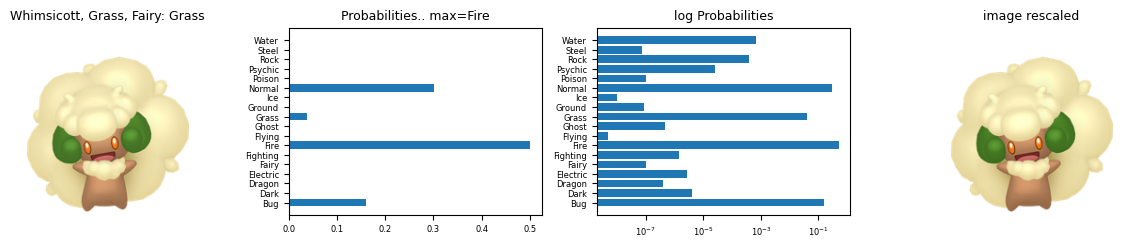

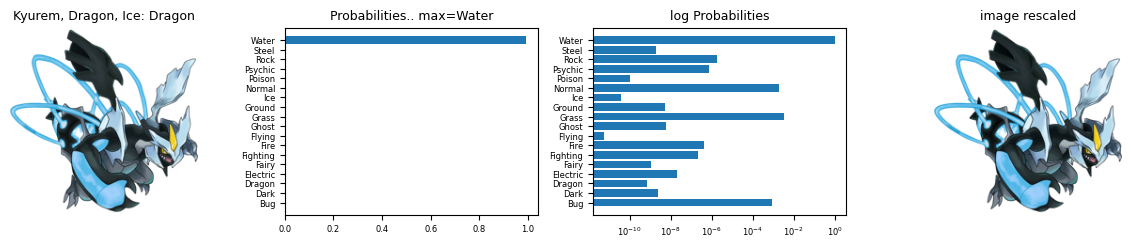

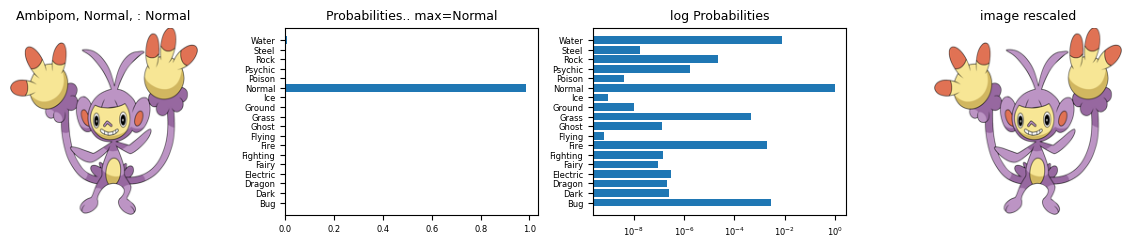

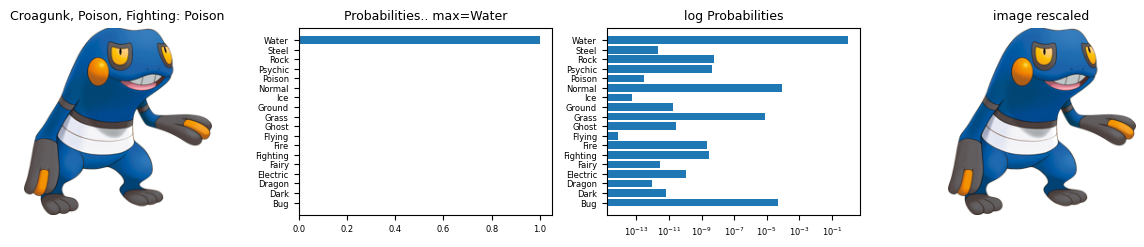

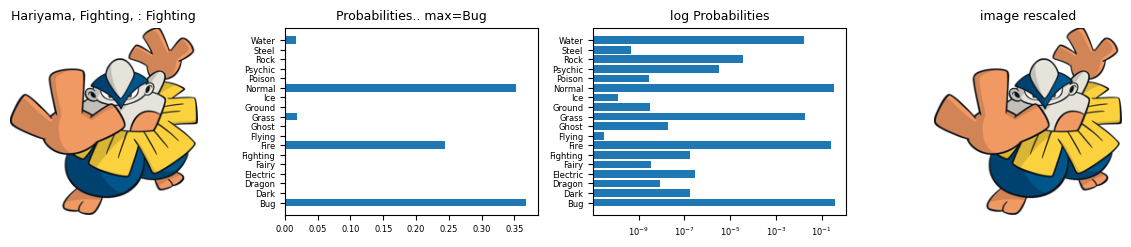

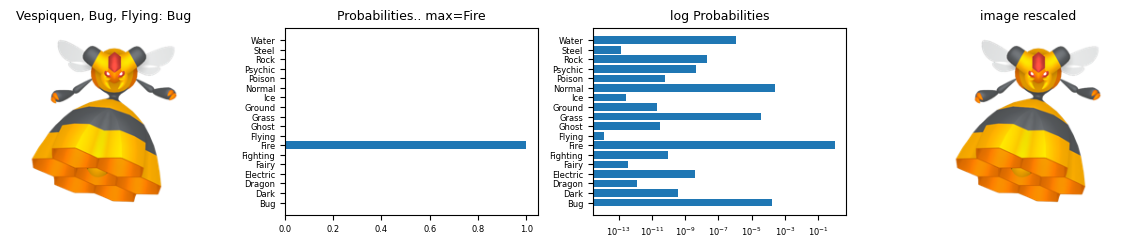

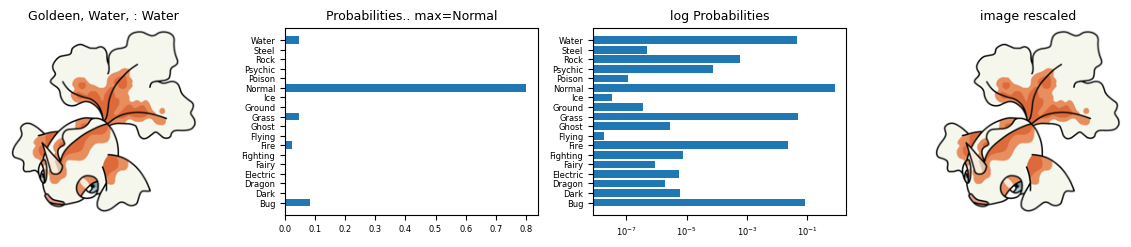

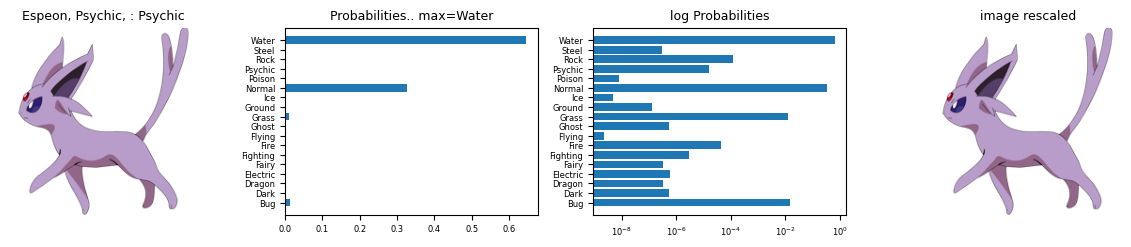

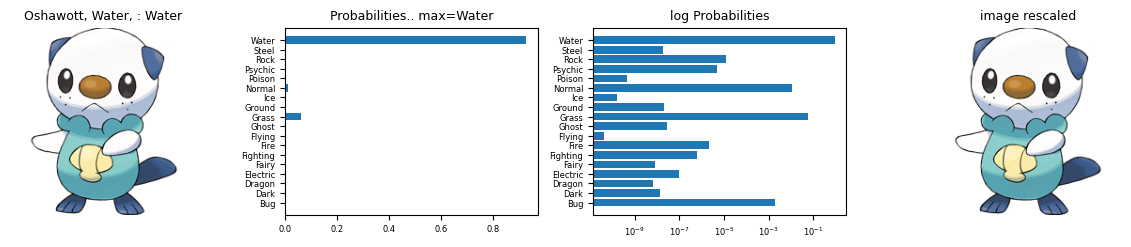

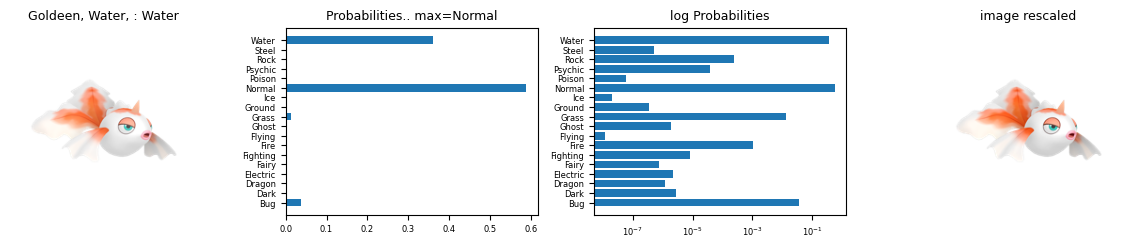

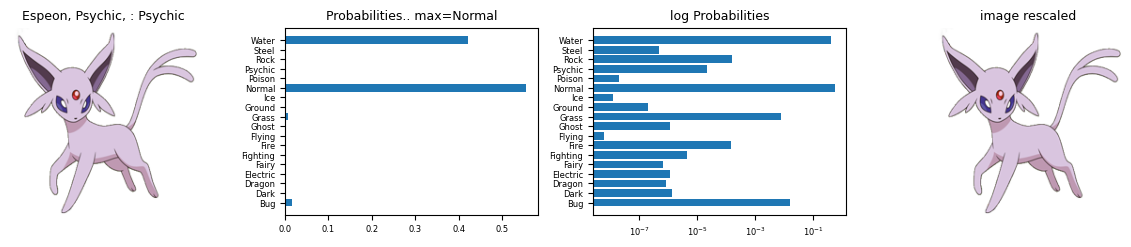

In [52]:
## plot prediction probabilities for some of the pokemon in the test set

istart = 0
istop  = 50
NSAMPLES = istop - istart
slicer = np.s_[istart:istop]

lbl_to_type = dp.idx_to_type

imgs = dd.val_data[slicer]
lbls = dd.val_labels[slicer]
nms  = dd.val_serials[slicer]
preds = model.predict(imgs)

for i in range(NSAMPLES):
    fig, axs = plt.subplots(1, 4, figsize=[12, 2.5])
    plt.sca(axs[0])
    plt.imshow(imgs[i])
    arr = np.array(lbls[i])
    index = np.where(arr == 1)
    plt.title(', '.join(nms[i])+': '+str(lbl_to_type(lbls[i])))
    plt.axis("off")

    plt.sca(axs[1])
    plt.title("Probabilities.. max="+str(lbl_to_type(dp.prediction_to_idx(preds[i]))))
    plt.barh(CLASSES, preds[i])
    
    plt.sca(axs[2])
    plt.title("log Probabilities")
    plt.barh(CLASSES, preds[i])
    plt.xscale('log')
    
    plt.sca(axs[3])
    ip.plt_rescaled(imgs[i])
    plt.title('image rescaled')
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()